# Advanced usage

### python test class


### config files

Provide option to input config files, in the form I want to get, if they don't provide any, you give/use default values. 
.txt format

Describe it in the documentation how it should look like.

In [3]:
from openTSNE import TSNEEmbedding
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger


import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In [4]:
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris["data"], iris["target"]

In [5]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 150 samples with 4 features


## Create train/test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [7]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

100 training samples
50 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [8]:
class KNNIndex_Elements:
    def __init__(self, metric, metric_params=None, n_jobs=1, random_state=None):
        self.index = None
        self.metric = metric
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.random_state = random_state

    def build(self, data):
        """Build the index so we can query nearest neighbors."""

    def query_train(self, data, k):
        """Query the index for the points used to build index."""

    def query(self, query, k):
        """Query the index with new points."""

    def check_metric(self, metric):
        """Check that the metric is supported by the KNNIndex instance."""

class Annoy:
    """
    """
    
#####       
#self.knn_index = build_knn_index(
#            data, method, metric, metric_params, n_jobs, random_state
#        )

### import affinity_multiann.py

In [9]:
import logging
import operator
from functools import reduce

import numpy as np
import scipy.sparse as sp

#from . import nearest_neighbors

log = logging.getLogger(__name__)

from openTSNE.affinity import PerplexityBasedNN, MultiscaleMixture, FixedSigmaNN, joint_probabilities_nn
from openTSNE import nearest_neighbors

class MultiANNPerplexityBasedNN(PerplexityBasedNN):
    """Compute affinities using nearest neighbors.
    """

    #super init !    
    def __init__(
        self,
        data,
        perplexity=30,
        method="approx",
        metric="euclidean",
        metric_params=None,
        symmetrize=True,
        n_jobs=1,
        random_state=None,
    ):
        self.n_samples = data.shape[0]
        self.perplexity = self.check_perplexity(perplexity)

        self.knn_index = build_knn_index(
            data, method, metric, metric_params, n_jobs, random_state
        )

        # Find and store the nearest neighbors so we can reuse them if the
        # perplexity is ever lowered
        k_neighbors = min(self.n_samples - 1, int(3 * self.perplexity))
        self.__neighbors, self.__distances = self.knn_index.query_train(
            data, k=k_neighbors
        )
        #print("Neighbors:")
        #print(self.__neighbors)
        #print(len(self.__neighbors))
        #print("Distances:")
        #print(self.__distances)
        #print(len(self.__distances[0]))

        self.P = joint_probabilities_nn(
            self.__neighbors,
            self.__distances,
            [self.perplexity],
            symmetrize=symmetrize,
            n_jobs=n_jobs,
        )

        self.n_jobs = n_jobs
        
        
        
def build_knn_index(
    data, method, metric, metric_params=None, n_jobs=1, random_state=None
):
    methods = {
        #"exact_alt": nearest_neighbors.VPTree,
        "exact": nearest_neighbors.BallTree,
        "approx": nearest_neighbors.NNDescent,
        #cs: options for ann algorithms
        "balltree": nearest_neighbors.BallTree,
        "nndescent": nearest_neighbors.NNDescent,
        #"annoy": multi_nearest_neighbors.Annoy, (if filelocation in sumfile)
        #"annoy": algorithms.annoy.Annoy (if filelocation in folder)
        "annoy": Annoy,
        #"hnswlib": Hnswlib,
        #"rpforest": RPForest,
        #"flann": FLANN,
        #"onng": ONNG,
        "nearpy": NearPy,
    }
    if isinstance(method, nearest_neighbors.KNNIndex):
        knn_index = method

    elif method not in methods:
        raise ValueError(
            "Unrecognized nearest neighbor algorithm `%s`. "
            "Please choose one of the supported methods or "
            "provide a valid `KNNIndex` instance." % method
        )
    else:
        knn_index = methods[method](
            metric=metric,
            metric_params=metric_params,
            n_jobs=n_jobs,
            random_state=random_state,
        )

    knn_index.build(data)

    return knn_index        

In [10]:
# class MultiANNFixedSigmaNN(FixedSigmaNN):
#     """Compute affinities using using nearest neighbors and a fixed bandwidth
#     for the Gaussians in the ambient space.
# 
#     Using a fixed Gaussian bandwidth can enable us to find smaller clusters of
#     data points than we might be able to using the automatically determined
#     bandwidths using perplexity. Note however that this requires mostly trial
#     and error.
#     """
# 
#     def __init__(
#         self,
#         data,
#         sigma,
#         k=30,
#         method="exact",
#         metric="euclidean",
#         metric_params=None,
#         symmetrize=True,
#         n_jobs=1,
#         random_state=None,
#     ):
#         self.n_samples = n_samples = data.shape[0]
# 
#         if k >= self.n_samples:
#             raise ValueError(
#                 "`k` (%d) cannot be larger than N-1 (%d)." % (k, self.n_samples)
#             )
# 
#         knn_index, neighbors, distances = build_knn_index(
#             data, method, k, metric, metric_params, n_jobs, random_state
#         )
# 
#         self.knn_index = knn_index
# 
#         # Compute asymmetric pairwise input similarities
#         conditional_P = np.exp(-distances ** 2 / (2 * sigma ** 2))
#         conditional_P /= np.sum(conditional_P, axis=1)[:, np.newaxis]
# 
#         P = sp.csr_matrix(
#             (conditional_P.ravel(), neighbors.ravel(), range(0, n_samples * k + 1, k)),
#             shape=(n_samples, n_samples),
#         )
# 
#         # Symmetrize the probability matrix
#         if symmetrize:
#             P = (P + P.T) / 2
# 
#         # Convert weights to probabilities
#         P /= np.sum(P)
# 
#         self.sigma = sigma
#         self.k = k
#         self.P = P
#         self.n_jobs = n_jobs
#
#
# class MultiANNMultiscaleMixture(MultiscaleMixture):
#     """Calculate affinities using a Gaussian mixture kernel.
# 
#     Instead of using a single perplexity to compute the affinities between data
#     points, we can use a multiscale Gaussian kernel instead. This allows us to
#     incorporate long range interactions.
#     """
# 
#     def __init__(
#         self,
#         data,
#         perplexities,
#         method="exact",
#         metric="euclidean",
#         metric_params=None,
#         symmetrize=True,
#         n_jobs=1,
#         random_state=None,
#     ):
#         self.n_samples = data.shape[0]
# 
#         # We will compute the nearest neighbors to the max value of perplexity,
#         # smaller values can just use indexing to truncate unneeded neighbors
#         perplexities = self.check_perplexities(perplexities)
#         max_perplexity = np.max(perplexities)
#         k_neighbors = min(self.n_samples - 1, int(3 * max_perplexity))
# 
#         self.knn_index, self.__neighbors, self.__distances = build_knn_index(
#             data, method, k_neighbors, metric, metric_params, n_jobs, random_state
#         )
# 
#         self.P = self._calculate_P(
#             self.__neighbors,
#             self.__distances,
#             perplexities,
#             symmetrize=symmetrize,
#             n_jobs=n_jobs,
#         )
# 
#         self.perplexities = perplexities
#         self.n_jobs = n_jobs
# 
# class MultiANNMultiscale(MultiANNMultiscaleMixture):
#     """Calculate affinities using averaged Gaussian perplexities.
# 
#     In contrast to :class:`MultiscaleMixture`, which uses a Gaussian mixture
#     kernel, here, we first compute single scale Gaussian kernels, convert them
#     to probability distributions, then average them out between scales.
# 
#     Please see the :ref:`parameter-guide` for more information.
#     """
# 
#     @staticmethod
#     def _calculate_P(
#         neighbors,
#         distances,
#         perplexities,
#         symmetrize=True,
#         normalization="pair-wise",
#         n_reference_samples=None,
#         n_jobs=1,
#     ):
#         # Compute normalized probabilities for each perplexity
#         partial_Ps = [
#             joint_probabilities_nn(
#                 neighbors,
#                 distances,
#                 [perplexity],
#                 symmetrize=symmetrize,
#                 normalization=normalization,
#                 n_reference_samples=n_reference_samples,
#                 n_jobs=n_jobs,
#             )
#             for perplexity in perplexities
#         ]
#         # Sum them together, then normalize
#         P = reduce(operator.add, partial_Ps, 0)
# 
#         # Take care to properly normalize the affinity matrix
#         if normalization == "pair-wise":
#             P /= np.sum(P)
#         elif normalization == "point-wise":
#             P = sp.diags(np.asarray(1 / P.sum(axis=1)).ravel()) @ P
# 
#         return P

### import multi_nearest_neighbors.py

### annparameters.py

In [11]:
def init_method_param(method, data=None):
    """
    Get method parameters based on approximate nearest neighbor algorithm and data (shape, vector)
    
    Input: name of method as string, data as np.array ([num_items][vector_length])
    Output: method_param as directory. Keys corresponding to the method-specific parameters
    """
    config_file = ""
    config_file = None

    if method == "nearpy":
        if not config_file:
            mp = {}
            
            # number of bits, as int
            mp['n_bits'] = 4 # ????? How many as standard? 
            
            # hash counts, as int
            mp['hash_counts'] = 5 # ????? How many as standard? 
    
    elif method == "annoy":

        if not config_file:
            n_items, vector_length = data.shape
            mp = {}
            
            # number of trees, as int
            mp["ntrees"] = 5 + int(round((n_items) ** 0.5 / 20))
    
    else:
        print("Error: ANN for init_method_param not found")
        return 
        
    return mp

In [12]:
print(init_method_param("nearpy"))

{'n_bits': 4, 'hash_counts': 5}


### NearPy

In [81]:
from openTSNE.nearest_neighbors import KNNIndex
import nearpy
from nearpy.filters import NearestFilter
import sklearn.preprocessing

class NearPy(KNNIndex):
    #VALID_METRICS = neighbors.NearPy.valid_metrics
    #METHOD_PARAMS = neighbors.NearPy.params (text/config file)
    
    def build(self, data): 
        n_items, vector_length = data.shape
        print(data.shape)
        #parameters init
        method_param = init_method_param("nearpy")
        self.filter = NearestFilter(10)
        
        hashes = []
        for k in range(method_param["hash_counts"]):
            nearpy_rbp = nearpy.hashes.RandomBinaryProjections(
                'rbp_%d' % k, method_param["n_bits"])
            hashes.append(nearpy_rbp)

        if self.metric == 'euclidean':
            dist = nearpy.distances.EuclideanDistance()
            self.index = nearpy.Engine(
                vector_length,
                lshashes=hashes,
                distance=dist,
                vector_filters=[self.filter])
        else:  # Default (angular) = Cosine distance
            self.index = nearpy.Engine(
                vector_length,
                lshashes=hashes,
                vector_filters=[self.filter])
            
        #if self.metric == 'angular':
            #data = sklearn.preprocessing.normalize(data, axis=1, norm='l2')
        for i, x in enumerate(data):
            self.index.store_vector(x, i)
            
    def query_train(self, data, k):
        self.filter.N = k
        #if self.metric == 'angular':
            #data = sklearn.preprocessing.normalize([data], axis=1, norm='l2')[0]
        
        neighbors = np.empty((data.shape[0],k), dtype=int)
        distances = np.empty((data.shape[0],k))
        
        for i in range(len(data)):
            item_single = self.index.neighbours(data[i])
            dp_n = []
            dp_d = []
            for j in range(len(item_single)):
                dp_n.append(item_single[j][1])
                dp_d.append(item_single[j][2])
            neighbors[i] = np.asarray(dp_n)
            distances[i] = np.asarray(dp_d)
            
        return neighbors, distances

    def query(self, query, k):
        self.filter.N = k
        #if self.metric == 'angular':
        #    query = sklearn.preprocessing.normalize([query], axis=1, norm='l2')[0]
        neighbors = np.empty((data.shape[0],k), dtype=int)
        distances = np.empty((data.shape[0],k))
        
        for i in range(len(data)):
            item_single = self.index.neighbours(data[i])
            dp_n = []
            dp_d = []
            for j in range(len(item_single)):
                dp_n.append(item_single[j][1])
                dp_d.append(item_single[j][2])
            neighbors[i] = np.asarray(dp_n)
            distances[i] = np.asarray(dp_d)
            
        return neighbors, distances

### ONNG:

In [ ]:
#from __future__ import absolute_import
import ngtpy
import numpy as np

class ONNG(KNNIndex):
    #VALID_METRICS = neighbors.ONNG.valid_metrics
    
    def build(self, data):
        #metrics = {'euclidean': '2', 'angular': 'C'}
        self._metric = metrics[metric]
        self._object_type
        self._edge_size_for_search = -2
        self._build_time_limit = 4
        self._epsilon = epsilon
        if self.method_param == None:
            self.method_param['edge'] == 0.0
            self.method_param['outdegree'] == 0.0
            self.method_param['indegree'] == 0.0

        dim = len(data[0])
        index_dir = 'indexes'
        if not os.path.exists(index_dir):
            os.makedirs(index_dir)
        index = os.path.join(
            index_dir,
            'ONNG-{}-{}-{}'.format(self._edge_size, self._outdegree,
                                   self._indegree))
        anngIndex = os.path.join(index_dir, 'ANNG-' + str(self._edge_size))
        if (not os.path.exists(index)) and (not os.path.exists(anngIndex)):
            t = time.time()
            args = ['ngt', 'create', '-it', '-p8', '-b500', '-ga', '-of',
                    '-D' + self._metric, '-d' + str(dim),
                    '-E' + str(self._edge_size), '-S0',
                    '-e' + str(self._epsilon), '-P0', '-B30',
                    '-T' + str(self._build_time_limit), anngIndex]
            subprocess.call(args)
            idx = ngtpy.Index(path=anngIndex)
            idx.batch_insert(X, num_threads=24, debug=False)
            idx.save()
            idx.close()
        if not os.path.exists(index):
            t = time.time()
            args = ['ngt', 'reconstruct-graph', '-mS',
                    '-o ' + str(self._outdegree),
                    '-i ' + str(self._indegree), anngIndex, index]
            subprocess.call(args)
        if os.path.exists(index):
            t = time.time()
            self.index = ngtpy.Index(index, read_only=True)
            self.indexName = index
        else:
            print('ONNG: Problem.')
        
            
    def query_train(self, data, k):    
        neighbors, distances = self.index.search(
            v, k, self._epsilon, self._edge_size_for_search,
            with_distance=False)
        return neighbors, distances
        
        
    def query(self, query, k):
        #check in what format results are, get neighbors, distances
        neighbors, distances = self.index.search(
            v, k, self._epsilon, self._edge_size_for_search,
            with_distance=False)
        return neighbors, distances

### FLANN:

In [ ]:
class FLANN(KNNIndex):
    #VALID_METRICS = neighbors.Flann.valid_metrics
    
    def build(self, data):
        #parameters init
        if self.method_param == None:
            self.method_param = {}
            self.method_param['target_precision'] = 0.9  # want 90% target precision  
        self._metric = metric
        
        self.index = pyflann.FLANN(
            target_precision=self._target_precision,
            algorithm='autotuned', 
            log_level='info')
        if self._metric == 'angular':
            data = sklearn.preprocessing.normalize(data, axis=1, norm='l2')
        self.index.build_index(data)


###### 
    def query_train(self, data, k):
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        if v.dtype != numpy.float32:
            v = v.astype(numpy.float32)
        return self._flann.nn_index(v, n)[0][0]

    def query(self, query, k):
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        if v.dtype != numpy.float32:
            v = v.astype(numpy.float32)
        return self._flann.nn_index(v, n)[0][0]

### RPForest:

In [ ]:
import rpforest
import numpy


class RPForest(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self, data):
        n_trees = 5 + int(round((data.shape[0]) ** 0.5 / 20))
        #n_iters = max(5, int(round(np.log2(data.shape[0]))))
        leaf_size = ?
        
        self.index = rpforest.RPForest(leaf_size=leaf_size, no_trees=n_trees)
        
        #if data.dtype != numpy.double:
        #    data = numpy.array(data).astype(numpy.double)
        self.index.fit(data)

    def query_train(self, data, k):
        neighbors, distances = self._model.query(data[0], k)
        return neighbors, distances

    def query(self, query, k):
        neighbors, distances = self._model.query(data[0], k)
        return neighbors, distances

### Hnswlib:

In [ ]:
%time

import hnswlib
import numpy as np


class HnswLib(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self,data):  
        #parameter init
        #self.metric = {'angular': 'cosine', 'euclidean': 'l2'}[metric]
        if self.method_param == None:
            self.method_param = {}
            self.method_param["efConstruction"] = 200
            self.method_param["M"] = 16
            self.method_param["efRecall"] = 10
            #self.name = 'hnswlib (%s)' % (self.method_param)
        
        
        self.index = hnswlib.Index(space=self.metric, dim=len(data[0]))
        self.index.init_index(max_elements=len(data),
                          ef_construction=self.method_param["efConstruction"],
                          M=self.method_param["M"])
        data_labels = np.arange(len(data))
        self.index.add_items(np.asarray(data), data_labels)
        self.index.set_num_threads(self.n_jobs)
        self.index.set_ef(self.method_param["efRecall"])

    def query(self, query, k):
        neighbors, distances = self.index.knn_query(query, k=k)
        return neighbors, distances
    
    def query_train(self, data, k):
        neighbors, distances = self.index.knn_query(data, k=k)
        return neighbors, distances

### Annoy:

In [13]:
from openTSNE.nearest_neighbors import KNNIndex
import annoy
import numpy as np

class Annoy(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self, data):
        n_items, vector_length = data.shape
        #initalize parameters
        method_param = init_method_param("annoy", data)
        #build index
        self.index = annoy.AnnoyIndex(vector_length, metric=self.metric)
        for i in range(n_items):
            self.index.add_item(i, data[i])
        self.index.build(method_param["ntrees"])
        
    def query_train(self, data, k):
        #add search_k parameter: tradeoff between speed and accuracy?
        #neighbors_single, distances_single = np.asarray(self.index.get_nns_by_vector(data[i], n=k, search_k=-1, include_distances=True))
        #output array with points x neighbors:
        neighbors = np.empty((data.shape[0],k), dtype=int)
        distances = np.empty((data.shape[0],k))
        for i in range(len(data)):
            neighbors_single, distances_single = np.asarray(self.index.get_nns_by_item(i, n=k, search_k=-1 ,include_distances=True))
            neighbors[i] = neighbors_single
            distances[i] = distances_single
        print("neighbors.shape: {}".format(neighbors.shape))
        print("neighbors[0]: {}".format(neighbors[0]))
        print(neighbors.shape)
        print("distances.shape: {}".format(distances.shape))
        print("distances[0]: {}".format(distances[0]))
        return neighbors, distances

    def query(self, query, k):
        neighbors = np.empty((query.shape[0],k), dtype=int)
        distances = np.empty((query.shape[0],k))
        for i in range(len(query)):
            neighbors_single, distances_single = np.asarray(self.index.get_nns_by_vector(query[i], n=k, search_k=-1, include_distances=True))
            neighbors[i] = neighbors_single
            distances[i] = distances_single
        return neighbors, distances

In [214]:
### Test:

In [215]:
affinities_train = MultiANNPerplexityBasedNN(
    x,
    perplexity=30,
    method="annoy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

#possible solution
#affinities_train.knn_index = stelmach.build_knn_index()

print("P:")
print(affinities_train.P)
print("")

#print("data:")
#print(affinities_train.data)
#print("")

print("knn_index:")
print(affinities_train.knn_index)

#print(".index")
#print(affinities_train.index)


neighbors.shape: (150, 90)
neighbors[0]: [  0  17   4  28  27  39   7  40  49  37  21  48  26  19  46  11  35  10
  31  36  20  34  43   9  23   2   6  30   1  29  25  16  47  12  24  45
  44   5  32  22   3  18  42  33  38  14   8  13  15  41  98  57  93  79
  64  81  60  80  69  59  82  88  67  92  89  99  95  71  53  96  62  94
  61  90  97  84  55  74  66  85  78 106  91  75  51  87  65  73  63  58]
(150, 90)
distances.shape: (150, 90)
distances[0]: [0.         0.10000001 0.14142123 0.14142123 0.1414213  0.1414213
 0.17320499 0.17320505 0.2236068  0.24494879 0.30000004 0.30000022
 0.31622773 0.33166245 0.36055511 0.37416551 0.37416565 0.37416592
 0.38729846 0.41231066 0.43589005 0.45825756 0.45825759 0.46904159
 0.46904165 0.509902   0.51961523 0.5385164  0.5385164  0.53851658
 0.54772258 0.5477227  0.58309519 0.59160781 0.59160781 0.59160781
 0.61644137 0.61644155 0.62449968 0.64807403 0.64807415 0.74161977
 0.76811439 0.80622566 0.86602527 0.88317627 0.92195427 0.99498719
 1.1045

affinities_train = MultiANNPerplexityBasedNN(
    x,
    perplexity=30,
    method="approx",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

#possible solution
#affinities_train.knn_index = stelmach.build_knn_index()

print("P:")
print(affinities_train.P)
print("")

#print("data:")
#print(affinities_train.data)
#print("")

print("knn_index:")
print(affinities_train.knn_index)

#print(".index")
#print(affinities_train.index)


**2. Generate initial coordinates for our embedding**

In [72]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 1.23 ms, sys: 331 µs, total: 1.56 ms
Wall time: 1.28 ms


**3. Construct the `TSNEEmbedding` object**

In [74]:
%time 
affinities_train = MultiANNPerplexityBasedNN(
    x_train,
    perplexity=30,
    method="nearpy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)


%time

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs
(100, 4)
90
dp_n: [99, 30, 56, 44, 42, 89, 10, 1, 49, 67, 23, 41, 87, 65, 86, 20, 61, 77, 76, 53, 83, 17, 48, 81, 93, 4, 22, 92, 34, 80, 63, 96, 73, 27, 43, 59, 45, 14, 36, 39, 2, 60, 70, 54, 26, 25, 69, 57, 85, 9, 90, 88, 0, 72, 66, 33, 98, 19, 75, 16, 91, 5, 62, 95, 29, 24, 79, 68, 40, 11, 13, 71, 12, 8, 38, 94, 46, 50, 35, 84, 28, 15, 37, 18, 52, 31, 78, 55, 64, 6]
neighbors.shape: (100, 90)
dp_d: [0.0, 0.0019011171323550652, 0.0225228806620157, 0.028793654123802474, 0.02988671710970274, 0.03016191181211454, 0.03229629357291395, 0.03518415699213469, 0.036324830807021466, 0.036588578780322525, 0.0368718722235618, 0.037535817399332184, 0.03778058997274837, 0.03814427259033656, 0.03894892502606243, 0.04096514591638589, 0.04256846107100718, 0.045444465449819366, 0.04562060121971979, 0.047830360700910894, 0.04819583973081753, 0.048317609429275134, 0.04927222481140128, 0.05190188557524535, 0.05483399586863565, 0.056741675006712

**4. Optimize embedding**

1. Early exaggeration phase

In [75]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  1.4553, 50 iterations in 3.3415 sec
Iteration  100, KL divergence  1.3531, 50 iterations in 1.8559 sec
Iteration  150, KL divergence  1.3554, 50 iterations in 1.7392 sec
Iteration  200, KL divergence  1.2295, 50 iterations in 1.4231 sec
Iteration  250, KL divergence  1.3845, 50 iterations in 1.9390 sec
CPU times: user 10.1 s, sys: 235 ms, total: 10.3 s
Wall time: 10.4 s


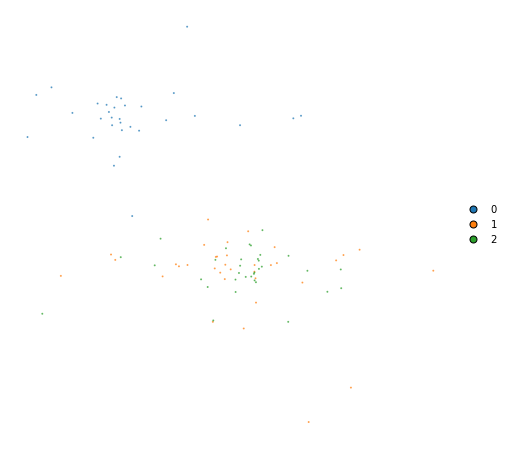

In [76]:
import utils

utils.plot(embedding_train_1, y_train)

In [77]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

Iteration   50, KL divergence  0.3022, 50 iterations in 1.6101 sec
Iteration  100, KL divergence  0.0682, 50 iterations in 1.4713 sec
Iteration  150, KL divergence  0.0120, 50 iterations in 1.3806 sec
Iteration  200, KL divergence  0.0060, 50 iterations in 1.5536 sec
Iteration  250, KL divergence  0.0065, 50 iterations in 1.6140 sec
Iteration  300, KL divergence  0.0072, 50 iterations in 1.6572 sec
Iteration  350, KL divergence  0.0069, 50 iterations in 1.4969 sec
Iteration  400, KL divergence  0.0064, 50 iterations in 1.4461 sec
Iteration  450, KL divergence  0.0059, 50 iterations in 1.4587 sec
Iteration  500, KL divergence  0.0058, 50 iterations in 1.3939 sec
Iteration  550, KL divergence  0.0062, 50 iterations in 1.3041 sec
Iteration  600, KL divergence  0.0062, 50 iterations in 1.3175 sec
Iteration  650, KL divergence  0.0061, 50 iterations in 1.3489 sec
Iteration  700, KL divergence  0.0057, 50 iterations in 1.4616 sec
Iteration  750, KL divergence  0.0053, 50 iterations in 1.3931

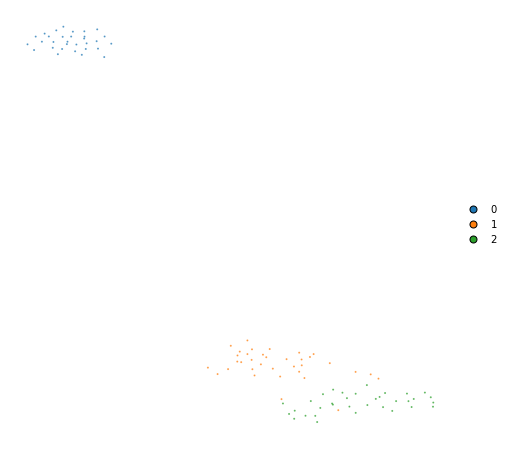

In [78]:
utils.plot(embedding_train_2, y_train)

## Transform

In [79]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

ValueError: shapes (4,4) and (50,4) not aligned: 4 (dim 1) != 50 (dim 0)

In [80]:
utils.plot(embedding_test, y_test)

NameError: name 'embedding_test' is not defined

In [ ]:
%%time
embedding_test_1 = embedding_test.optimize(
    n_iter=100,
    learning_rate=1,
    exaggeration=2,
    momentum=0,
)

In [ ]:
utils.plot(embedding_test_1, y_test)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
utils.plot(embedding_train_2, y_train, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, alpha=0.75, ax=ax)

---

### Test inheritance:

In [ ]:
class base():
    def __init__(self):
        init = "Init Base"
        print(init)
    def bark(self):
        print("woof")
        
#currently (full override):
class over(base):
    def __init__(self):
        init = "Init Previous"
        print(init)
    def berk(self):
        print("dog.bark(self)")

billo = dug()  

#with super:
class sup(base):
    def __init__(self):
        super(deg, self).__init__()
        init = "Init Super"
        print(init)
    def berk(self):
        print("dog.bark(self)")

bello = deg()

### Test numpy array:

In [ ]:
import numpy as np

print("x.shape: {}".format(x.shape))
arr = np.empty(x.shape)
#print("arr: {}".format(arr))
entry = [0,1,2,3]
arr[0] = entry
print("arr + entry {}".format(arr[0]))

In [ ]:
import numpy as np

#index = neighbors, distances
data = [[[0,1,2,3],[0,20,30,40]],[[1,1,2,3],[10,20,30,40]],[[2,1,2,3],[20,20,30,40]],
[[3,1,2,3],[30,20,30,40]],[[4,1,2,3],[40,20,30,40]]]

neighbors = np.empty((5,4))
distances = np.empty((5,4))

for i in range(len(data)):
    #neighbors_single, distances_single = np.asarray(data[i])
    neighbors[i], distances[i] = np.asarray(data[i])
#    neighbors[i] = neighbors_single
#    distances[i] = distances_single
      
print(neighbors)
print(distances)






#indexarr = np.asarray(indexlist)
#np.append(indexarr[1],np.asarray(indexlist1)[1], axis=0)
#neig, dist = indexarr[1]
#np.append(indexarr[0],np.asarray(indexlist1)[1], axis=0)

#print(indexarr)


#neigh = np.empty((4,4))
#dist = np.empty

#empty[0] = indexarr[0]
#print("")
#print(empty)




#### Test difference range, enumerate for data

In [ ]:
#X = [[1,2,3],[4,5,6]]
     
#for i,x in enumerate(X):
#    print(i,x)
    
#n_items, vector_length = x.shape
#for i, j in range(n_items):
#    print(j[i], i)
#print("")
#for i,j in enumerate(x):
#    print(i,j)